In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from geopy.distance import great_circle as vc 
import math as Math
import tensorflow
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import datetime
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Dense, Conv2D, TimeDistributed, LSTM, MaxPooling2D, Flatten
import math, time
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
import os

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
BASIN = 'WP' # Change to BASIN you want to work for

seed = 1
#Setting random seeds
def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(seed)
   np.random.seed(seed)
   random.seed(seed)
    
reset_random_seeds()

path = os.getcwd()+'/'

Num GPUs Available:  2


In [3]:
# We will be using only those cyclone which has length at least 5
#Generating a desription of such cyclones
filePath = path + BASIN + 'pressureSSTData.csv'
data = pd.read_csv(filePath, index_col=0)
keys = list(enumerate(pd.unique(data['SID'])))
total_hurricane_count = len(pd.unique(data['SID']))
y = []
for x in range(0,total_hurricane_count):
    length = len(pd.DataFrame(data[data['SID'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    if length >=5: 
        y.append(length)
    
hurricane_amount = pd.DataFrame(y)
hurricane_amount.describe()

0
count  1064.000000
mean     36.810150
std      27.880434
min       5.000000
25%      16.000000
50%      28.000000
75%      51.250000
max     199.000000

In [ ]:
# The average time to landfall is given by 36.81*3 + 9 (We are taking data 12 hour before landfall, last data point is landfall location data)

In [4]:
filePath = path + BASIN + 'pressureSSTData.csv'
data = pd.read_csv(filePath, index_col=0)

keys = list(enumerate(pd.unique(data['SID'])))
total_hurricane_count = len(pd.unique(data['SID']))

y = np.zeros((total_hurricane_count))
for x in range(0,total_hurricane_count):
    y[x] = len(pd.DataFrame(data[data['SID'] == keys[x][1]], columns = data.keys()).reset_index(drop = True))
    
hurricane_amount = pd.DataFrame(y)

# Keeping all hurricanes with length >=4 (though we will be using hurricnes with length >=5 (4+1))
cond = hurricane_amount >= 5
keys25 = []

for x in cond.index:
    if cond.loc[x][0]:
        keys25.append(keys[x][1])
    
data = data[data['SID'].isin(keys25)]
print('data shape (containing cyclone with length >=5) ',data.shape)
total_hurricane_count = len(pd.unique(data['SID']))
print("total hurricane count  ", total_hurricane_count)

#Selecting a huricqne for reuslts representation. One can change it to any cyclone.
namedHurricane = data[data['SID'].str.contains('2019310N14116')] # NAKRI cyclone
print('namedHurricane Shape', namedHurricane.shape)
#Removing this named cyclone data from main data
data = data[~data['SID'].str.contains('2019310N14116')]

#Normalizing the columns with standard scaler
scalers = {}
notToNormalize = ['LAT','LON']
columnsToNormalize = ['LAT','LON']
for i in range(1089):
  columnsToNormalize.append('u225_'+str(i))
  columnsToNormalize.append('u500_'+str(i))
  columnsToNormalize.append('u700_'+str(i))
  columnsToNormalize.append('v225_'+str(i))
  columnsToNormalize.append('v500_'+str(i))
  columnsToNormalize.append('v700_'+str(i))
  columnsToNormalize.append('z225_'+str(i))
  columnsToNormalize.append('z500_'+str(i))
  columnsToNormalize.append('z700_'+str(i))
  columnsToNormalize.append('sst_'+str(i))

for col in columnsToNormalize:
  scaler = StandardScaler()
  scaler.fit(data[[col]])
  scalers[col] =  scaler
  if not col in notToNormalize:
    data[[col]] = scaler.transform(data[[col]])
  
data_pad = []

for key in np.unique(data['SID']):
    data_pad += [data[ data.loc[:, 'SID'] == key].loc[:, columnsToNormalize].values]

#Normalizing the features of namedCyclone with the scaler fitted on main data. 
for col in columnsToNormalize:
  scaler = scalers[col]
  if not col in notToNormalize:
    namedHurricane[[col]] = scaler.transform(namedHurricane[[col]])

data_padF = []
data_padF += [namedHurricane.loc[:, columnsToNormalize].values]

data shape (containing cyclone with length >=5)  (39166, 10897)
total hurricane count   1064
namedHurricane Shape (37, 10897)


In [5]:
# Extracting features indexes and adjusting them as per used features. We are not using Wind speed, pressure, distance to land as feature 
latIndex = data.columns.get_loc('LAT') - 2
longIndex = data.columns.get_loc('LON') - 2


u225fIndex = data.columns.get_loc('u225_0')-5
u225lIndex = data.columns.get_loc('u225_1088')-5 
v225fIndex = data.columns.get_loc('v225_0')-5
v225lIndex = data.columns.get_loc('v225_1088')-5 
z225fIndex = data.columns.get_loc('z225_0')-5
z225lIndex = data.columns.get_loc('z225_1088')-5 

u500fIndex = data.columns.get_loc('u500_0')-5
u500lIndex = data.columns.get_loc('u500_1088')-5 
v500fIndex = data.columns.get_loc('v500_0')-5
v500lIndex = data.columns.get_loc('v500_1088')-5 
z500fIndex = data.columns.get_loc('z500_0')-5 
z500lIndex = data.columns.get_loc('z500_1088')-5 

u700fIndex = data.columns.get_loc('u700_0')-5 
u700lIndex = data.columns.get_loc('u700_1088')-5 
v700fIndex = data.columns.get_loc('v700_0')-5 
v700lIndex = data.columns.get_loc('v700_1088')-5 
z700fIndex = data.columns.get_loc('z700_0')-5 
z700lIndex = data.columns.get_loc('z700_1088')-5 

sstfIndex = data.columns.get_loc('sst_0')-5 
sstlIndex = data.columns.get_loc('sst_1088')-5 

gridSize = 33

#Function to create grid of latitudes and longitudes
def getGrid(lati,long, scalers):
  gridSize = 33

  latScaler = scalers['LAT']
  lonScaler = scalers['LON']

  latis = np.linspace(lati-4, lati+4,gridSize)
  longs = np.linspace(long-4, long+4,gridSize)

  latis = latis.reshape((gridSize,1))
  longs = longs.reshape((gridSize,1))

  latis = latScaler.transform(latis)
  longs = lonScaler.transform(longs)

  latis = latis.reshape((1,gridSize))[0]
  longs = longs.reshape((1,gridSize))[0]

  latisGrid = np.random.random((gridSize,gridSize))
  longsGrid = np.random.random((gridSize,gridSize))

  for i in range(gridSize):
    latisGrid[i,:] = latis[i]
    longsGrid[:,i] = longs[i]

  return latisGrid, longsGrid

#Training dataset prepearation.
# If target = location, lat-long of landfall is the target. If target = time, time to landfall is the target. 
def load_data(data_pad, trainPoints, scalers, target='location'):
    X = []
    y = []
    count  = 0
    for cdata in data_pad:
      count = count + 1
      length = len(cdata)
      diff = length - trainPoints
      if diff > 0:
        ylati = cdata[length-1][[latIndex]]
        ylong = cdata[length-1][[longIndex]]
        latScaler = scalers['LAT']
        lonScaler = scalers['LON']
        hours = (diff-1) *3.0 + 12.0

        ylati = latScaler.transform([ylati])[0]
        ylong = lonScaler.transform([ylong])[0]
        yy = [ylati[0],ylong[0]]

        for i in range(diff):
          cc = cdata[i : i + trainPoints]
          data2 = []
          if target == 'time':
              yy = hours - i*3.0
          for j in range(trainPoints):
            data1 = []
            value = cc[j]
            lati = value[latIndex]
            long = value[longIndex]
            latisGrid,longsGrid = getGrid(lati,long, scalers)
            u225 = np.reshape(value[u225fIndex: u225lIndex+1], (gridSize,gridSize))
            u500 = np.reshape(value[u500fIndex: u500lIndex+1], (gridSize,gridSize))
            u700 = np.reshape(value[u700fIndex: u700lIndex+1], (gridSize,gridSize))

            v225 = np.reshape(value[v225fIndex: v225lIndex+1], (gridSize,gridSize))
            v500 = np.reshape(value[v500fIndex: v500lIndex+1], (gridSize,gridSize))
            v700 = np.reshape(value[v700fIndex: v700lIndex+1], (gridSize,gridSize))

            z225 = np.reshape(value[z225fIndex: z225lIndex+1], (gridSize,gridSize))
            z500 = np.reshape(value[z500fIndex: z500lIndex+1], (gridSize,gridSize))
            z700 = np.reshape(value[z700fIndex: z700lIndex+1], (gridSize,gridSize))
            sst = np.reshape(value[sstfIndex: sstlIndex+1], (gridSize,gridSize))

            data1.append(latisGrid)
            data1.append(longsGrid)
            data1.append(u225)
            data1.append(u500)
            data1.append(u700)
            data1.append(v225)
            data1.append(v500)
            data1.append(v700)
            data1.append(z225)
            data1.append(z500)
            data1.append(z700)
            data1.append(sst)
            data2.append(data1)
          X.append(data2)
          y.append(yy)

    X = np.array(X)
    y = np.array(y)
    x_train = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2], X.shape[3],X.shape[4])) 
    return [x_train, y]

# Get MAE RMSE on original latitude, longitude 
def getMaeRmse(predictions, y_test, scalers):
  length = len(predictions)
  latiScaler = scalers['LAT']
  longScaler = scalers['LON']
  #Extracting predicted and acutal latis
  latisP = predictions[:,0]
  longsP = predictions[:,1]
  latisA = y_test[:,0]
  longsA = y_test[:,1]

  latisA = np.reshape(latisA,(length,1))
  longsA = np.reshape(longsA,(length,1))
  latisP = np.reshape(latisP,(length,1))
  longsP = np.reshape(longsP,(length,1))

  #Getting actual values of latitiude/longitude
  latisA = latiScaler.inverse_transform(latisA)
  longsA = longScaler.inverse_transform(longsA)
  latisP = latiScaler.inverse_transform(latisP)
  longsP = longScaler.inverse_transform(longsP)

  testScorela = mean_squared_error(latisA, latisP)
  testScorelo = mean_squared_error(longsA, longsP)

  testScorelaMae = mean_absolute_error(latisA, latisP)
  testScoreloMae = mean_absolute_error(longsA, longsP)

  return np.sqrt(testScorela), np.sqrt(testScorelo), testScorelaMae, testScoreloMae

def getMaeRmseTime(predictions, y_test):

  testScore = mean_squared_error(predictions, y_test)
  testScoreMae = mean_absolute_error(predictions, y_test)

  return np.sqrt(testScore), testScoreMae

#Get distance between preidcted locatin and acutal landfall location
def getDistance(predictions, y_test, scalers):
  length = len(predictions)
  latiScaler = scalers['LAT']
  longScaler = scalers['LON']
  latisP = predictions[:,0]
  longsP = predictions[:,1]
  latisA = y_test[:,0]
  longsA = y_test[:,1]

  latisA = np.reshape(latisA,(length,1))
  longsA = np.reshape(longsA,(length,1))
  latisP = np.reshape(latisP,(length,1))
  longsP = np.reshape(longsP,(length,1))

  latisA = latiScaler.inverse_transform(latisA)
  longsA = longScaler.inverse_transform(longsA)
  latisP = latiScaler.inverse_transform(latisP)
  longsP = longScaler.inverse_transform(longsP)
  dist = 0
  distM = 0
  for i in range(length):
    actualCor = [latisA[i][0], longsA[i][0]]
    predictedCor = [latisP[i][0], longsP[i][0]]
    dist = dist + vc(actualCor, predictedCor).kilometers
    distM = distM + vc(actualCor, predictedCor).miles

  return dist/length, distM/length

#Model definition
def build_model(inputShape, noOfPredFeatures=2):
    model = Sequential()
    model.add(TimeDistributed(Conv2D(filters=32, kernel_size=(4, 4), activation = 'relu',data_format = 'channels_first'), input_shape=inputShape[1:]))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=48, kernel_size=(4, 4), activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Conv2D(filters=64, kernel_size=(3, 3), activation = 'relu', data_format = 'channels_first')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2),data_format = 'channels_first')))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(64, activation='relu', return_sequences=True))
    model.add(LSTM(32, activation='relu', return_sequences=False))
    model.add(Dense(noOfPredFeatures))
    model.compile(loss="mse", optimizer='adam')
    return model

In [4]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = tf.Session(config=config)
callba = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 0, patience = 20, restore_best_weights=True)
trains = [4, 6, 8]
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("T (sizeo of training point) =   ", trainPoints)
  X, y = load_data(data_pad, trainPoints, scalers,'time')
  X, y = shuffle(X, y, random_state=0)
  print("No of train points", X.shape)
  kf = KFold(n_splits=5, shuffle=True,  random_state=0)

  scoresTime = []
  scoresMaeTime = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]

      model = build_model(X.shape, 1)
      history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split = 0.2, verbose=0, shuffle = True, callbacks = [callba])
      predictions = model.predict(X_test)

      mse, mae = getMaeRmseTime(predictions, y_test)
      scoresTime.append(mse)
      scoresMaeTime.append(mae)

      print('scores time  RMSE ', scoresTime)
      print('scores time  MAE', scoresMaeTime)   

  print("5 fold accuracy Time RMSE ",np.array(scoresTime).mean(), '  std   ', np.array(scoresTime).std())
  print("5 fold accuracy Time MAE ",np.array(scoresMaeTime).mean(), '  std   ', np.array(scoresMaeTime).std())


T (sizeo of training point) =    4
No of train points (34874, 4, 12, 33, 33)


W0123 21:55:31.081701 140137571874624 deprecation.py:323] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


scores time  RMSE  [11.038959700913095]
scores time  MAE [7.657415669895842]
scores time  RMSE  [11.038959700913095, 11.132603316535642]
scores time  MAE [7.657415669895842, 7.3137965018433055]
scores time  RMSE  [11.038959700913095, 11.132603316535642, 11.106966296092224]
scores time  MAE [7.657415669895842, 7.3137965018433055, 8.13484196666321]
scores time  RMSE  [11.038959700913095, 11.132603316535642, 11.106966296092224, 10.440542175213722]
scores time  MAE [7.657415669895842, 7.3137965018433055, 8.13484196666321, 7.201389214026885]
scores time  RMSE  [11.038959700913095, 11.132603316535642, 11.106966296092224, 10.440542175213722, 10.497369211453364]
scores time  MAE [7.657415669895842, 7.3137965018433055, 8.13484196666321, 7.201389214026885, 6.924099786800541]
5 fold accuracy Time RMSE  10.843288140041608   std    0.3076949848153833
5 fold accuracy Time MAE  7.446308627845957   std    0.41686722066746923
T (sizeo of training point) =    6
No of train points (32777, 6, 12, 33, 33)


In [4]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.6
session = tf.Session(config=config)
callba = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 0, patience = 20, restore_best_weights=True)
trains = [8]
for i in range(len(trains)):
  trainPoints = trains[i]
  print("===========================================================")
  print("T (sizeo of training point) =   ", trainPoints)
  X, y = load_data(data_pad, trainPoints, scalers)
  X, y = shuffle(X, y, random_state=0)
  print("No of train points", X.shape)
  kf = KFold(n_splits=5, shuffle=True,  random_state=0)

  scoresla = []
  scoreslaMae = []
  scoreslo = []
  scoresloMae = []

  scoresMi = []
  scoresKm = []

  for train_index, test_index in kf.split(X):
      X_train = X[train_index]
      y_train = y[train_index]
      X_test = X[test_index]
      y_test = y[test_index]

      model = build_model(X.shape)
      history = model.fit(X_train, y_train, batch_size=256, epochs=100, validation_split = 0.2, verbose=0, shuffle = True, callbacks = [callba])
      predictions = model.predict(X_test)

      rmsela, rmselo, msela, mselo = getMaeRmse(predictions, y_test, scalers)
      distKm, distMi = getDistance(predictions, y_test, scalers)

      scoresMi.append(distMi)
      scoresKm.append(distKm)
      scoresla.append(rmsela)
      scoreslo.append(rmselo)
      scoreslaMae.append(msela)
      scoresloMae.append(mselo)

      print('scores latitude  RMSE ', scoresla)
      print('scores longitude  RMSE', scoreslo)
    
      print('scores latitude Mae ', scoreslaMae)
      print('scores longitude  Mae', scoresloMae)

      print('distance Miles  ', scoresMi)
      print('distances KiloMeters  ', scoresKm)    

  print("5 fold accuracy Lati RMSE ",np.array(scoresla).mean(), '  std   ', np.array(scoresla).std())
  print("5 fold accuracy Long RMSE ",np.array(scoreslo).mean(), '  std   ', np.array(scoreslo).std())

  print("5 fold accuracy  Lati MAE",np.array(scoreslaMae).mean(), '  std   ', np.array(scoreslaMae).std())
  print("5 fold accuracy Long MAE",np.array(scoresloMae).mean(), '  std   ', np.array(scoresloMae).std())
  print("5 fold distance average Kilometers ",np.array(scoresKm).mean(), '  std   ', np.array(scoresKm).std())


T (sizeo of training point) =    8
No of train points (30791, 8, 12, 33, 33)


W0125 16:15:22.800822 140052983609152 deprecation.py:323] From /home/sandeepk/.local/lib/python3.7/site-packages/tensorflow_core/python/ops/math_grad.py:1424: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


scores latitude  RMSE  [0.803755436144307]
scores longitude  RMSE [1.1275891113912266]
scores latitude Mae  [0.5526855351993878]
scores longitude  Mae [0.7704897868433137]
distance Miles   [66.58586186920667]
distances KiloMeters   [107.1595572840363]
scores latitude  RMSE  [0.803755436144307, 0.9602968002902592]
scores longitude  RMSE [1.1275891113912266, 1.191247722637797]
scores latitude Mae  [0.5526855351993878, 0.7129333635899245]
scores longitude  Mae [0.7704897868433137, 0.8457408305828198]
distance Miles   [66.58586186920667, 78.82809794272588]
distances KiloMeters   [107.1595572840363, 126.86152645553813]
scores latitude  RMSE  [0.803755436144307, 0.9602968002902592, 0.8144776811448794]
scores longitude  RMSE [1.1275891113912266, 1.191247722637797, 1.1926924106698384]
scores latitude Mae  [0.5526855351993878, 0.7129333635899245, 0.5723519984789877]
scores longitude  Mae [0.7704897868433137, 0.8457408305828198, 0.8299894418298289]
distance Miles   [66.58586186920667, 78.8280979

In [6]:
# Result for the hurricane NAKRI (not part of training data).
trainPoints = 8
X, y = load_data(data_pad, trainPoints, scalers, 'time')
X, y = shuffle(X, y, random_state=0)
XFTime, yFTime = load_data(data_padF, trainPoints, scalers,'time')
model2 = build_model(X.shape, 1)
model2.fit(X, y, batch_size=256 ,epochs=100, shuffle = True, verbose = 0)
predictionsFTime = model2.predict(XFTime)
mse, mae = getMaeRmseTime(predictionsFTime, yFTime)
print('rmse  ', mse,  '   mae  ', mae)

rmse   9.030623950034885    mae   7.659710193502492


trainPoints   8


<Figure size 720x720 with 0 Axes>

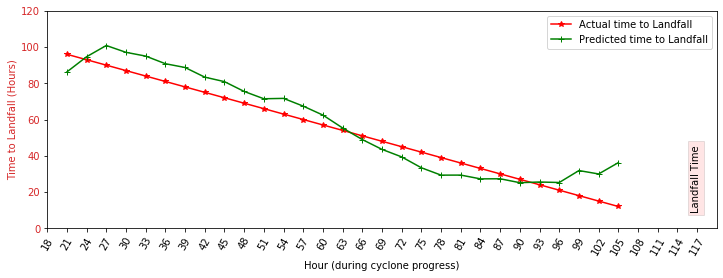

In [7]:
#Representing location prediction results for NAKRI hurricane

print("trainPoints  ", trainPoints)
lengthF = len(yFTime)

plt.figure(figsize=(10, 10))
fig, ax1 = plt.subplots(figsize=(12, 4))
a = np.linspace(1,lengthF+4+8,lengthF+4+8)*3 - 6
aa = np.linspace(1,lengthF,lengthF)*3 + 6*3
aaa = np.linspace(1,lengthF+4,lengthF+4)*3 + 6*3

color = 'tab:red'
ax1.set_xlabel('Hour (during cyclone progress)')
ax1.set_ylabel('Time to Landfall (Hours)', color=color)
ax1.plot(aa, yFTime, marker = '*',label = "Actual time to Landfall",color = 'red')
ax1.plot(aa, predictionsFTime, marker = '+',label = "Predicted time to Landfall",color ='green')
ax1.tick_params(axis='y', labelcolor=color)
ax1.xaxis.set_ticks(a)
plt.xticks(rotation=60)
plt.ylim((0,120))
ax1.legend(loc=1)
plt.xlim((18,120))
ax1.text(116, 10, 'Landfall Time', rotation=90, bbox={'facecolor': 'red', 'alpha': 0.1, 'pad': 3})
plt.show()